## L'Oreal Project

In [797]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import plotly.graph_objects as go 
import seaborn as sns 
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from scipy.stats import pearsonr
from scipy.optimize import differential_evolution
from skopt import gp_minimize


In [798]:
prices_df = pd.read_csv('data/commercial_variables.csv')
a_and_p_df = pd.read_csv('data/a&p_variables.csv')
a_and_p_definition_df = pd.read_csv('data/a&p_variables_definition.csv')
kpi_definition_df = pd.read_csv('data/kpi_&_com_variables_definition.csv')
kpi_model_df = pd.read_csv('data/kpi_to_model.csv')
merged_df = pd.read_csv('data/merged_data.csv')


In [799]:
kpi_model_df.drop('Year', axis=1, inplace=True)
kpi_model_df.set_index('Starting Week', inplace=True)

In [800]:
fig = go.Figure()

# Add traces for each column
for col in kpi_model_df.columns:
    fig.add_trace(go.Scatter(y=kpi_model_df[col], x=kpi_model_df.index, mode='lines', name=col))

# Customize layout
fig.update_layout(
    title="Online and Offline Sellout Value and Units",
    xaxis_title="Date",
    yaxis_title="Value",
    legend_title="Columns",
)

# Show figure
fig.show()


Easier to model the sales units rather than value

In [801]:
sellout_units_df = kpi_model_df.iloc[:,[1,3]]

In [802]:
fig = go.Figure()

# Add traces for each column
for col in sellout_units_df.columns:
    fig.add_trace(go.Scatter(y=sellout_units_df[col], x=sellout_units_df.index, mode='lines', name=col))

# Customize layout
fig.update_layout(
    title="Online and Offline Sellout Units",
    xaxis_title="Date",
    yaxis_title="Value",
    legend_title="Columns",
)

# Show figure
fig.show()


Building a model for OOH sales 

In [803]:
# Isolate OOH sales units
OOH_units = sellout_units_df.iloc[:,0]

# Align the features
OOH_frame = a_and_p_df.set_index('Starting week')
OOH_frame['Sales_Units'] = OOH_units

# Now take in the commercial price related data 
prices_df.drop('Year', axis=1, inplace=True)
prices_df.set_index('Starting Week', inplace=True)

OOH_frame = pd.merge(left=OOH_frame, right=prices_df, how='left', left_index=True, right_index=True)


Make some forward lags of sales units

In [804]:
OOH_frame.rename(columns={'Sales_Units':'Sales_Units_t'}, inplace=True)

# Assuming OOH_frame is your DataFrame
OOH_frame['Sales_Units_t+1'] = OOH_frame['Sales_Units_t'].shift(-1)  # Forward lag of 1
OOH_frame['Sales_Units_t+2'] = OOH_frame['Sales_Units_t'].shift(-2)  # Forward lag of 2
OOH_frame['Sales_Units_t+3'] = OOH_frame['Sales_Units_t'].shift(-3)  # Forward lag of 3


Interesting to look at the offline discount to online

In [805]:
Offline_Avg_price = OOH_frame.iloc[:,9]  # Easier than specifying the full name
Online_Avg_price = OOH_frame.iloc[:,10]

OOH_frame['Offline_Discount_t'] = ((Offline_Avg_price - Online_Avg_price) / (Offline_Avg_price)) * 100

col_names = list(OOH_frame.columns)
OOH_frame.drop(col_names[10], axis=1, inplace=True)
# Rename the column to something more manageable 
OOH_frame.rename(columns={col_names[9]: 'Offline_Avg_Price', col_names[11]: 'Weighted_Promotion_Distribution'},inplace=True)  



Also compute some forward lags on the offline discount 

In [806]:
OOH_frame['Offline_Discount_t+1'] = OOH_frame['Offline_Discount_t'].shift(-1)  # Forward lag of 1
OOH_frame['Offline_Discount_t+2'] = OOH_frame['Offline_Discount_t'].shift(-2)  # Forward lag of 2
OOH_frame['Offline_Discount_t+3'] = OOH_frame['Offline_Discount_t'].shift(-3)  # Forward lag of 3

Drop the level 1 distinction - its constant

In [807]:
print(OOH_frame['growth_driver_l1'].unique())

# We drop it 
OOH_frame.drop('growth_driver_l1', axis=1, inplace=True)


['ap_consumer_facing']


In [808]:
OOH_frame

,growth_driver_l2,growth_driver_l3,growth_driver_l4,growth_driver_l5,metric,investment (in pound),execution,Sales_Units_t,Offline_Avg_Price,Weighted_Promotion_Distribution,Sales_Units_t+1,Sales_Units_t+2,Sales_Units_t+3,Offline_Discount_t,Offline_Discount_t+1,Offline_Discount_t+2,Offline_Discount_t+3
Starting week,,,,,,,,,,,,,,,,,
2022-01-03,consumer_engagement,advocacy_media,influencer_management,influencer_management,engagements,107.438017,537.216943,681362.5,2.323822,0.37,753049.7,710890.7,729487.2,-39.514642,-27.920478,-26.731924,-28.386212
2022-01-10,consumer_engagement,advocacy_media,influencer_management,influencer_management,engagements,0.000000,0.000000,753049.7,2.328649,0.42,710890.7,729487.2,738346.7,-27.920478,-26.731924,-28.386212,-38.071158
2022-01-17,consumer_engagement,advocacy_media,influencer_management,influencer_management,engagements,0.000000,0.000000,710890.7,2.378280,0.43,729487.2,738346.7,721747.0,-26.731924,-28.386212,-38.071158,-31.605457
2022-01-24,consumer_engagement,advocacy_media,influencer_management,influencer_management,engagements,28484.999998,142432.121596,729487.2,2.396989,0.86,738346.7,721747.0,687971.7,-28.386212,-38.071158,-31.605457,-28.992541
2022-01-31,consumer_engagement,advocacy_media,influencer_management,influencer_management,engagements,19172.915190,95869.369418,738346.7,2.394615,0.78,721747.0,687971.7,686506.6,-38.071158,-31.605457,-28.992541,-26.102886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-27,shopper_experience,shopper_experience,testers_and_merchandising,testers_and_merchandising,units,0.000000,0.000000,806178.1,3.067400,0.91,810641.0,878861.1,1069429.4,-22.957313,-24.503542,-25.498482,-23.993277
2023-12-04,shopper_experience,shopper_experience,testers_and_merchandising,testers_and_merchandising,units,0.000000,0.000000,810641.0,3.039699,0.81,878861.1,1069429.4,606425.3,-24.503542,-25.498482,-23.993277,-43.629705
2023-12-11,shopper_experience,shopper_experience,testers_and_merchandising,testers_and_merchandising,units,3381.443000,193.700000,878861.1,3.057034,0.81,1069429.4,606425.3,NaN,-25.498482,-23.993277,-43.629705,NaN


In [809]:
OOH_frame.head()

,growth_driver_l2,growth_driver_l3,growth_driver_l4,growth_driver_l5,metric,investment (in pound),execution,Sales_Units_t,Offline_Avg_Price,Weighted_Promotion_Distribution,Sales_Units_t+1,Sales_Units_t+2,Sales_Units_t+3,Offline_Discount_t,Offline_Discount_t+1,Offline_Discount_t+2,Offline_Discount_t+3
Starting week,,,,,,,,,,,,,,,,,
2022-01-03,consumer_engagement,advocacy_media,influencer_management,influencer_management,engagements,107.438017,537.216943,681362.5,2.323822,0.37,753049.7,710890.7,729487.2,-39.514642,-27.920478,-26.731924,-28.386212
2022-01-10,consumer_engagement,advocacy_media,influencer_management,influencer_management,engagements,0.000000,0.000000,753049.7,2.328649,0.42,710890.7,729487.2,738346.7,-27.920478,-26.731924,-28.386212,-38.071158
2022-01-17,consumer_engagement,advocacy_media,influencer_management,influencer_management,engagements,0.000000,0.000000,710890.7,2.378280,0.43,729487.2,738346.7,721747.0,-26.731924,-28.386212,-38.071158,-31.605457
2022-01-24,consumer_engagement,advocacy_media,influencer_management,influencer_management,engagements,28484.999998,142432.121596,729487.2,2.396989,0.86,738346.7,721747.0,687971.7,-28.386212,-38.071158,-31.605457,-28.992541
2022-01-31,consumer_engagement,advocacy_media,influencer_management,influencer_management,engagements,19172.915190,95869.369418,738346.7,2.394615,0.78,721747.0,687971.7,686506.6,-38.071158,-31.605457,-28.992541,-26.102886


In [810]:
OOH_frame['growth_driver_l5'].unique()

array(['influencer_management', 'bvod', 'amazon_retail', 'tesco',
       'google_video', 'youtube', 'google', 'amazon', 'citrus', 'criteo',
       'meta', 'pinterest', 'tik_tok', 'meta_collab_ads', 'the_hut_group',
       'linear', 'testers_and_merchandising'], dtype=object)

In [811]:
OOH_frame['metric'].unique()

array(['engagements', 'impressions', 'grps', 'units'], dtype=object)

In [812]:
OOH_frame['growth_driver_l4'].unique()

array(['influencer_management', 'digital_tv',
       'online_multiformat_ads_transaction',
       'online_video_content_platforms',
       'paid_search_awarenessconsideration', 'paid_search_transaction',
       'social_media_awarenessconsideration', 'social_media_transaction',
       'traditional_tv', 'testers_and_merchandising'], dtype=object)

In [813]:
l5_levers = OOH_frame['growth_driver_l5'].unique()
l4_levers = OOH_frame['growth_driver_l4'].unique()

print('Number of l5 levers', len(l5_levers))
print('l5_levers:', l5_levers)

print()

print('Number of l4 levers', len(l4_levers))
print('l4 levers:', l4_levers)

Number of l5 levers 17
l5_levers: ['influencer_management' 'bvod' 'amazon_retail' 'tesco' 'google_video'
 'youtube' 'google' 'amazon' 'citrus' 'criteo' 'meta' 'pinterest'
 'tik_tok' 'meta_collab_ads' 'the_hut_group' 'linear'
 'testers_and_merchandising']

Number of l4 levers 10
l4 levers: ['influencer_management' 'digital_tv' 'online_multiformat_ads_transaction'
 'online_video_content_platforms' 'paid_search_awarenessconsideration'
 'paid_search_transaction' 'social_media_awarenessconsideration'
 'social_media_transaction' 'traditional_tv' 'testers_and_merchandising']


Encode at the l4 level and make a modelling df

In [814]:
OOH_frame_cols = OOH_frame.columns
indices_to_drop = [0, 1, 3]
#indices_to_drop = [0, 1, 2]  # for l5
names = [OOH_frame_cols[x] for x in indices_to_drop]
Modelling_l4_df = OOH_frame.drop(columns=names, axis=1)

In [815]:
Modelling_l4_df.columns

Index(['growth_driver_l4', 'metric', 'investment (in pound)', 'execution',
       'Sales_Units_t', 'Offline_Avg_Price', 'Weighted_Promotion_Distribution',
       'Sales_Units_t+1', 'Sales_Units_t+2', 'Sales_Units_t+3',
       'Offline_Discount_t', 'Offline_Discount_t+1', 'Offline_Discount_t+2',
       'Offline_Discount_t+3'],
      dtype='object')

In [816]:
def create_lever_usage_plot(df):
    # Create a pivot table to reshape the data
    pivot_df = pd.pivot_table(
        df,
        values='investment (in pound)',
        index=df.index,  # This is your date
        columns='growth_driver_l4',
        #columns='growth_driver_l5',
        fill_value=0
    )
    
    # Create a stacked bar plot
    fig, ax = plt.subplots(figsize=(80, 45))  # Increase figure size
    pivot_df.plot(kind='bar', stacked=True, ax=ax)

    # Formatting
    plt.title('Marketing Lever Usage Over Time', fontsize=120)
    plt.xlabel('Date', fontsize=80)
    plt.ylabel('Investment Amount (£)', fontsize=80)
    plt.legend(title='Marketing Levers', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=60)
    
    # Adjust x-tick labels to prevent overlap
    xticks = range(0, len(pivot_df), max(1, len(pivot_df) // 20))  # Reduce number of x-ticks
    plt.xticks(xticks, pivot_df.index[xticks], rotation=30, ha='right', fontsize=35)

    plt.yticks(fontsize=40)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    return plt

# This creates a monthly look at the a and p levers 
def create_lever_heatmap(df):
    # Ensure index is in datetime format
    df = df.copy()
    df.index = pd.to_datetime(df.index)

    # Create a pivot table
    pivot_df = pd.pivot_table(
        df,
        values='investment (in pound)',
        index=pd.Grouper(freq='ME'),  
        columns='growth_driver_l4',
        #columns='growth_driver_l5',
        fill_value=0
    )
    
    # Create heatmap
    plt.figure(figsize=(15, 8))
    sns.heatmap(pivot_df, cmap='YlOrRd', annot=True, fmt='.0f')

    plt.title('Marketing Lever Usage Intensity Over Time')
    plt.xlabel('Marketing Levers')
    plt.ylabel('Date')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    return plt


<module 'matplotlib.pyplot' from 'c:\\Users\\35387\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

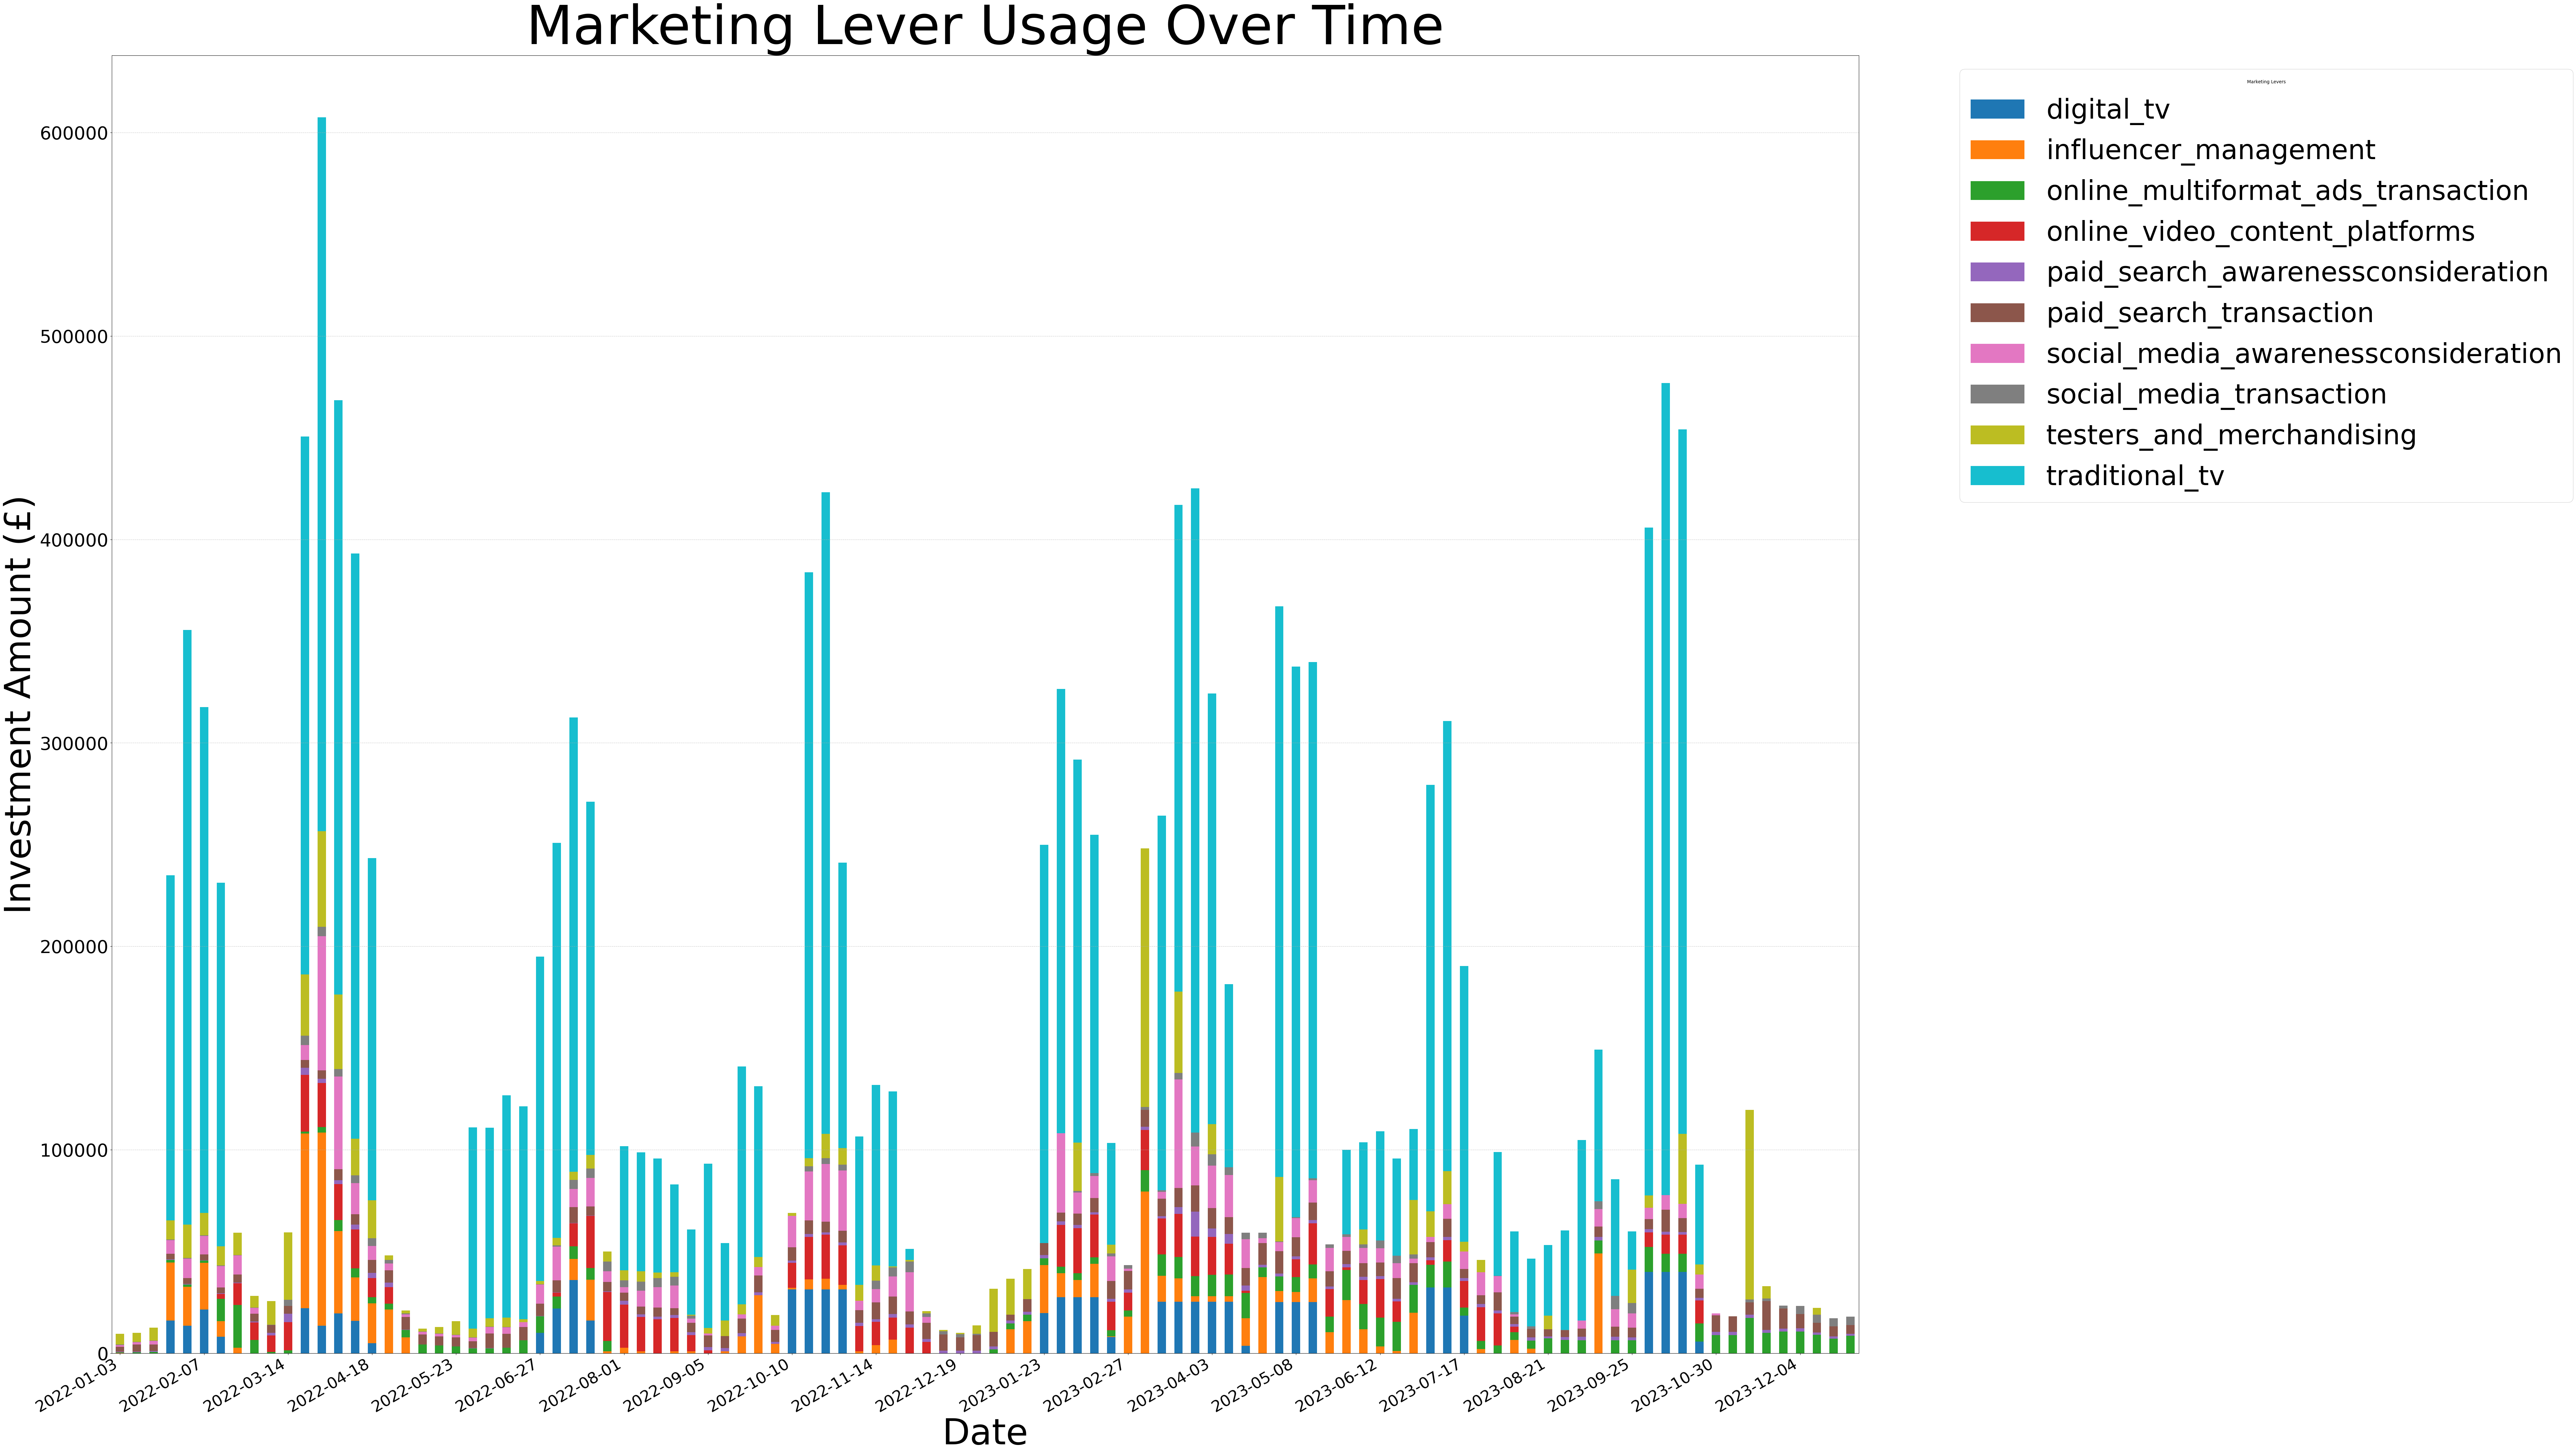

In [817]:
create_lever_usage_plot(Modelling_l4_df)

<module 'matplotlib.pyplot' from 'c:\\Users\\35387\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

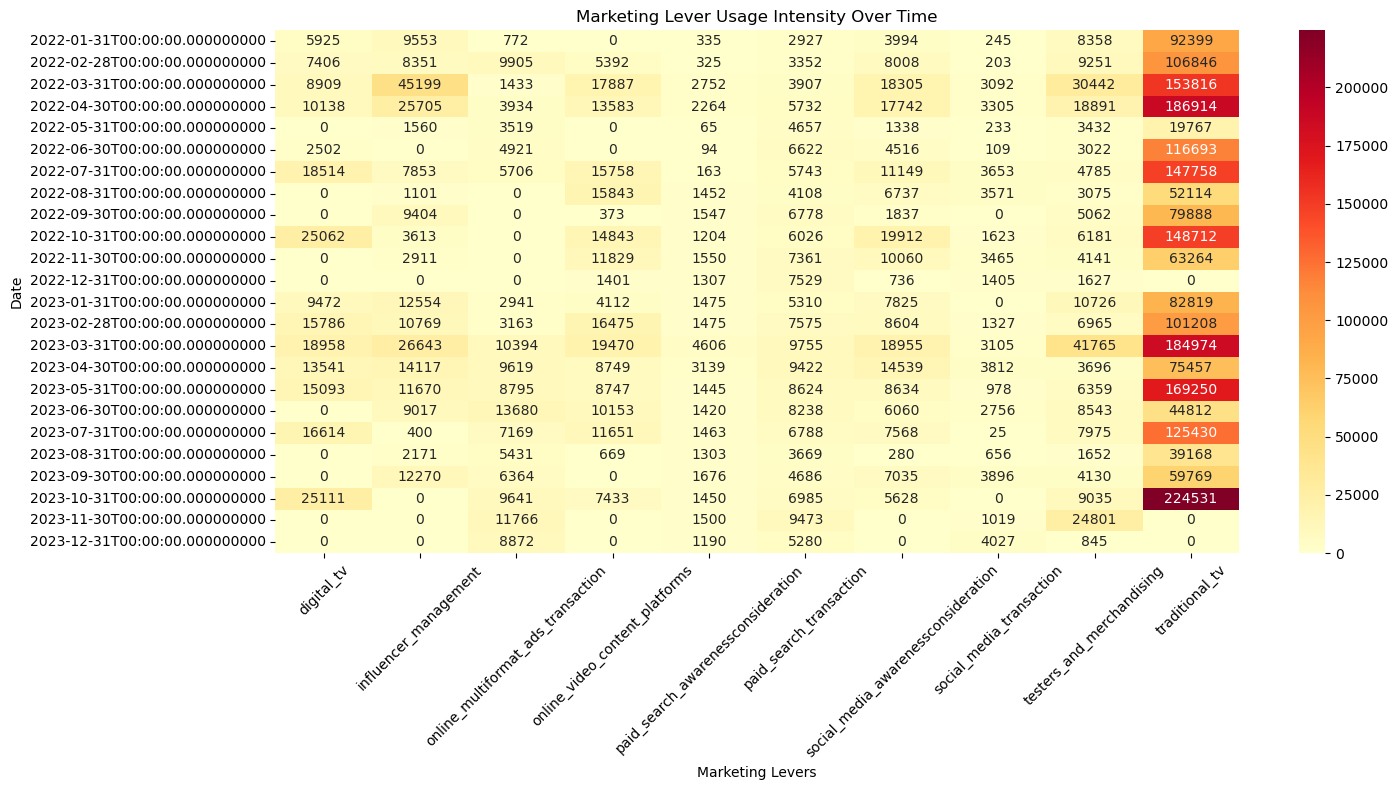

In [818]:
create_lever_heatmap(Modelling_l4_df)

In [819]:
Modelling_l4_df.head()
Modelling_l4_df.drop(columns=['metric', 'Offline_Avg_Price'], axis=1, inplace=True)

## Also add in some holiday variables

This is a function that will work on a grouped dataframe

In [820]:
def add_calendar_features_grouped(df_grouped):
    """Add calendar features to already grouped dataset"""
    dates = pd.to_datetime(df_grouped.index)
    
    # Create a DataFrame with the new features
    calendar_features = pd.DataFrame(index=dates)
    
    # Week of year for seasonality
    calendar_features['week_of_year'] = dates.isocalendar().week
    
    # Christmas period (weeks 51-52)
    calendar_features['christmas_period'] = ((dates.isocalendar().week >= 51) | 
                                           (dates.isocalendar().week == 1)).astype(int)
    
    # Sales period (weeks 1-4)
    calendar_features['sales_period'] = (dates.isocalendar().week <= 4).astype(int)
    
    # UK School Holidays (approximate main holidays)
    def is_school_holiday(date):
        month = date.month
        week = date.isocalendar().week
        
        # Summer holidays (mid July - early September)
        if month in [7, 8] or (month == 9 and week == 1):
            return 1
        # Christmas holidays
        elif month == 12 and week >= 51:
            return 1
        # Easter (approximate)
        elif month == 4:
            return 1
        # Half terms (approximate)
        elif (month == 2 and week in [7, 8]) or \
             (month == 5 and week in [22, 23]) or \
             (month == 10 and week in [43, 44]):
            return 1
        return 0
    
    calendar_features['school_holiday'] = dates.map(is_school_holiday)
    calendar_features['Starting week'] = df_grouped.index
    
    return calendar_features

In [821]:
# Example: One-hot encode the 'growth_driver_l4' column
Modelling_l4_df = pd.get_dummies(Modelling_l4_df, columns=['growth_driver_l4'])
#Modelling_l4_df = pd.get_dummies(Modelling_l4_df, columns=['growth_driver_l5'])


# Make sure the 'investment_in_pound' column exists and is numeric
Modelling_l4_df['investment_in_pound'] = pd.to_numeric(Modelling_l4_df['investment (in pound)'], errors='coerce')

# Multiply the one-hot encoded columns by the 'investment_in_pound'
growth_driver_columns = [col for col in Modelling_l4_df.columns if 'growth_driver_l4' in col]  # Find the dummies columns
#growth_driver_columns = [col for col in Modelling_l4_df.columns if 'growth_driver_l5' in col]  # Find the dummies columns

for col in growth_driver_columns:
    Modelling_l4_df[col] = Modelling_l4_df[col] * Modelling_l4_df['investment_in_pound']

# Drop the 'investment_in_pound' column now that it's been applied
Modelling_l4_df.drop(columns=['investment_in_pound'], inplace=True)

# Make sure the index is in datetime format (if it's not already)
Modelling_l4_df.index = pd.to_datetime(Modelling_l4_df.index)

# Group by week starting from Monday (change to 'W-SUN' if you prefer Sunday)
weekly_group = Modelling_l4_df.resample('W-MON').mean()

### Building a constrained regression in statsmodels

Change the fillna to dropna

In [822]:
def create_simplified_mmm(df):
    """
    Create a simplified Marketing Mix Model with key marketing channels.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe with marketing channels and target variable
    
    Returns:
    --------
    dict, dict, dict, np.array, np.array, pd.DataFrame
        Coefficients, model metrics, channel contributions, residuals, predictions, feature matrix
    """
    # Identify marketing channels (columns with 'l4' in name)
    marketing_cols = [col for col in df.columns if 'l4' in col.lower()]
    #marketing_cols = [col for col in df.columns if 'l5' in col.lower()]

    
    # Prepare feature matrix X and target variable y
    X = df[marketing_cols + 
           ['Weighted_Promotion_Distribution', 'Offline_Discount_t']]
    
    # Add intercept
    X['Intercept'] = 1.0
    
    # Target variable
    y = df['execution']
    
    # Convert to numpy arrays
    X_array = X.values
    y_array = y.values.astype(np.float64)
    
    # Initialize parameters
    beta_init = np.zeros(X_array.shape[1])
    beta_init[:-1] = 0.1  # Initialize marketing coefficients
    
    # Objective function with L2 regularization
    def objective(beta, alpha=0.01):
        return np.sum((y_array - X_array @ beta) ** 2) + alpha * np.sum(beta ** 2)
    
    # Constraints to ensure marketing coefficients are non-negative
    constraints = [{'type': 'ineq', 'fun': lambda beta, idx=i: beta[idx]} 
                   for i in range(len(marketing_cols))]
    
    # Fit constrained model
    result = minimize(
        objective,
        beta_init,
        method='SLSQP',
        constraints=constraints,
        options={'ftol': 1e-8, 'maxiter': 1000}
    )
    
    # Predictions and metrics
    y_pred = X_array @ result.x
    residuals = y_array - y_pred
    
    # R-squared calculations
    ss_tot = np.sum((y_array - np.mean(y_array)) ** 2)
    ss_res = np.sum(residuals ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    # Model metrics
    metrics = {
        'R_squared': r2,
        'Durbin_Watson': durbin_watson(residuals),
        'RMSE': np.sqrt(np.mean(residuals ** 2)),
        'Optimization_Success': result.success
    }
    
    # Coefficient dictionary
    coef_dict = dict(zip(X.columns, result.x))
    
    # Channel contributions
    contribution = {
        col: (coef_dict[col] * X[col].mean()) / y.mean() * 100 
        for col in marketing_cols
    }
    
    return coef_dict, metrics, contribution, residuals, y_pred, X

In [823]:

# # Function to print results
def print_mmm_results(coefficients, metrics, contribution):
    print("=== Model Coefficients ===")
    # Print marketing coefficients first
    print("\nMarketing Coefficients (Constrained >= 0):")
    for var, coef in coefficients.items():
        if 'channel_' in var:
            print(f"{var}: {coef:.4f}")
    
    print("\nOther Coefficients (Unconstrained):")
    for var, coef in coefficients.items():
        if 'channel_' not in var and var != 'const':
            print(f"{var}: {coef:.4f}")
    
    print("\n=== Performance Metrics ===")
    for metric, value in metrics.items():
        if isinstance(value, (int, float)):
            print(f"{metric}: {value:.4f}")
        else:
            print(f"{metric}: {value}")
    
    print("\n=== Marketing Channel Contribution (%) ===")
    for channel, contrib in contribution.items():
        print(f"{channel}: {contrib:.2f}%")

In [824]:
coefficients, metrics, contributions, residuals, predictions, features = create_simplified_mmm(weekly_group)
print_mmm_results(coefficients, metrics, contributions)

=== Model Coefficients ===

Marketing Coefficients (Constrained >= 0):

Other Coefficients (Unconstrained):
growth_driver_l4_digital_tv: 14.3457
growth_driver_l4_influencer_management: 13.7713
growth_driver_l4_online_multiformat_ads_transaction: 13.2473
growth_driver_l4_online_video_content_platforms: 25.3029
growth_driver_l4_paid_search_awarenessconsideration: 2.0680
growth_driver_l4_paid_search_transaction: 21.7894
growth_driver_l4_social_media_awarenessconsideration: 46.1876
growth_driver_l4_social_media_transaction: 11.2300
growth_driver_l4_testers_and_merchandising: 12.2670
growth_driver_l4_traditional_tv: 151.6660
Weighted_Promotion_Distribution: 0.1134
Offline_Discount_t: -0.4805
Intercept: 0.0212

=== Performance Metrics ===
R_squared: -0.1448
Durbin_Watson: 1.0434
RMSE: 717122.5711
Optimization_Success: False

=== Marketing Channel Contribution (%) ===
growth_driver_l4_digital_tv: 0.59%
growth_driver_l4_influencer_management: 0.59%
growth_driver_l4_online_multiformat_ads_trans

C:\Users\35387\AppData\Local\Temp\ipykernel_21668\3391827453.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [825]:

from scipy.stats import pearsonr

def apply_adstock(channel_spend, decay_rate=0.5):
    """
    Apply adstock transformation to marketing channels
    
    Parameters:
    -----------
    channel_spend : np.array
        Marketing channel spend
    decay_rate : float, optional
        Rate of decay for advertising effect (default 0.5)
    
    Returns:
    --------
    np.array: Adstocked channel spend
    """
    adstocked = np.zeros_like(channel_spend)
    adstocked[0] = channel_spend[0]
    
    for t in range(1, len(channel_spend)):
        adstocked[t] = channel_spend[t] + decay_rate * adstocked[t-1]
    
    return adstocked

def advanced_mmm(df, marketing_lag=4):
    """
    Advanced Marketing Mix Model with adstocking and sophisticated optimization
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe with marketing channels and target
    marketing_lag : int, optional
        Number of lags to consider for marketing effects
    
    Returns:
    --------
    dict: Comprehensive model results
    """
    # Identify marketing channels
    marketing_cols = [col for col in df.columns if 'l4' in col.lower()]
    
    # Prepare feature matrix
    X_features = []
    
    # Apply adstocking to marketing channels
    for col in marketing_cols:
        adstocked_channel = apply_adstock(df[col].fillna(0).values)
        X_features.append(adstocked_channel)
    
    # Add control variables
    X_features.append(df['Weighted_Promotion_Distribution'].values)
    X_features.append(df['Offline_Discount_t'].values)
    
    # Transpose to get correct shape
    X = np.column_stack(X_features)
    
    # Target variable
    y = df['execution'].values
    
    # Robust regression
    model = sm.RLM(y, sm.add_constant(X)).fit()
    
    # Advanced metrics
    predicted = model.predict()
    residuals = y - predicted
    
    # Calculate contributions
    contributions = {}
    for i, col in enumerate(marketing_cols + ['Promo_Distribution', 'Offline_Discount']):
        contributions[col] = np.abs(model.params[i+1] * X[:, i].mean() / y.mean()) * 100
    
    # Correlation analysis
    correlation, _ = pearsonr(y, predicted)
    
    return {
        'coefficients': dict(zip(['Intercept'] + marketing_cols + ['Promo_Distribution', 'Offline_Discount'], model.params)),
        'metrics': {
            'R_squared': model.rsquared,
            'Adj_R_squared': model.rsquared_adj,
            'Correlation': correlation,
            'AIC': model.aic,
            'BIC': model.bic
        },
        'contributions': contributions,
        'residuals': residuals,
        'predictions': predicted
    }

In [826]:
weekly_group

,investment (in pound),execution,Sales_Units_t,Weighted_Promotion_Distribution,Sales_Units_t+1,Sales_Units_t+2,Sales_Units_t+3,Offline_Discount_t,Offline_Discount_t+1,Offline_Discount_t+2,...,growth_driver_l4_digital_tv,growth_driver_l4_influencer_management,growth_driver_l4_online_multiformat_ads_transaction,growth_driver_l4_online_video_content_platforms,growth_driver_l4_paid_search_awarenessconsideration,growth_driver_l4_paid_search_transaction,growth_driver_l4_social_media_awarenessconsideration,growth_driver_l4_social_media_transaction,growth_driver_l4_testers_and_merchandising,growth_driver_l4_traditional_tv
Starting week,,,,,,,,,,,,,,,,,,,,,
2022-01-03,891.464921,2.431737e+05,681362.5,0.37,7.530497e+05,7.108907e+05,7.294872e+05,-39.514642,-27.920478,-26.731924,...,0.000000,5.654632,32.285842,0.0,19.730772,384.122139,122.226684,48.336087,279.108765,0.000000
2022-01-10,1064.964885,3.554044e+05,753049.7,0.42,7.108907e+05,7.294872e+05,7.383467e+05,-27.920478,-26.731924,-28.386212,...,0.000000,0.000000,56.056000,0.0,17.552030,535.521994,177.641579,45.645764,232.547518,0.000000
2022-01-17,1257.038839,4.317706e+05,710890.7,0.43,7.294872e+05,7.383467e+05,7.217470e+05,-26.731924,-28.386212,-38.071158,...,0.000000,0.000000,71.306368,0.0,19.533129,510.486818,270.389737,53.651582,331.671205,0.000000
2022-01-24,13464.569690,9.067656e+05,729487.2,0.86,7.383467e+05,7.217470e+05,6.879717e+05,-28.386212,-38.071158,-31.605457,...,850.448053,1499.210526,127.816684,0.0,18.961593,417.635236,1068.586316,57.986924,493.676989,8930.247368
2022-01-31,20126.558843,1.148133e+06,738346.7,0.78,7.217470e+05,6.879717e+05,6.865066e+05,-38.071158,-31.605457,-28.992541,...,708.706801,1009.100799,119.101211,0.0,12.508024,463.192025,1514.143527,51.962102,862.481196,15385.363158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-27,2969.362500,5.264074e+05,806178.1,0.91,8.106410e+05,8.788611e+05,1.069429e+06,-22.957313,-24.503542,-25.498482,...,0.000000,0.000000,1069.176550,0.0,70.545800,1489.989800,0.000000,339.650350,0.000000,0.000000
2023-12-04,3204.547450,5.433779e+05,810641.0,0.81,8.788611e+05,1.069429e+06,6.064253e+05,-24.503542,-25.498482,-23.993277,...,0.000000,0.000000,1068.893800,0.0,78.846300,1050.155600,0.000000,1006.651750,0.000000,0.000000
2023-12-11,2852.044000,4.068313e+05,878861.1,0.81,1.069429e+06,6.064253e+05,6.795625e+05,-25.498482,-23.993277,-43.629705,...,0.000000,0.000000,902.344950,0.0,57.396300,716.578850,0.000000,1006.651750,169.072150,0.000000


In [827]:
def advanced_constrained_mmm(df, max_adstock_lag=3):
    """
    Advanced Marketing Mix Model with sophisticated adstocking and constraints
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe with marketing channels
    max_adstock_lag : int
        Maximum lag for adstock transformation
    
    Returns:
    --------
    dict: Comprehensive model results
    """
    def adstock_transform(channel, decay_rate=0.5, max_lag=3):
        """
        Advanced adstock transformation with time-varying effects
        
        Parameters:
        -----------
        channel : np.array
            Raw channel spending
        decay_rate : float
            Decay rate for advertising effect
        max_lag : int
            Maximum number of periods for lag effect
        
        Returns:
        --------
        np.array: Transformed channel with lag effects
        """
        transformed = np.zeros_like(channel, dtype=float)
        
        for t in range(len(channel)):
            lag_effect = 0
            for l in range(1, max_lag + 1):
                if t - l >= 0:
                    lag_weight = (1 - decay_rate) ** l
                    lag_effect += channel[t-l] * lag_weight
            
            transformed[t] = channel[t] + decay_rate * lag_effect
        
        return transformed
    
    # Identify marketing channels
    marketing_cols = [col for col in df.columns if 'l4' in col.lower()]
    
    # Prepare feature matrix with advanced adstocking
    X_features = []
    for col in marketing_cols:
        # Different decay rates for different channels
        decay_rates = np.linspace(0.3, 0.7, len(marketing_cols))
        channel_adstock = adstock_transform(
            df[col].fillna(0).values, 
            decay_rate=decay_rates[marketing_cols.index(col)],
            max_lag=max_adstock_lag
        )
        X_features.append(channel_adstock)
    
    # Add control variables
    X_features.append(df['Weighted_Promotion_Distribution'].values)
    X_features.append(df['Offline_Discount_t'].values)
    X_features.append(df['Sales_Units_t'].values)
    X = np.column_stack(X_features)
    y = df['execution'].values
    
    # Objective function with L2 regularization and non-negativity
    def objective(beta, alpha=0.1):
        y_pred = X @ beta
        regularization = alpha * np.sum(beta**2)
        return np.sum((y - y_pred)**2) + regularization
    
    # Constraints for non-negative coefficients
    constraints = [{'type': 'ineq', 'fun': lambda x: x}]
    
    # Initial guess with reasonable starting values
    beta_init = np.ones(X.shape[1]) * 1.5
    
    result = differential_evolution(
        objective, 
        bounds=[(0, 90)] * X.shape[1],  # Constrain parameter ranges
        strategy='best1bin',
        popsize=15,  # Increase population size
        maxiter=1000
    )
    # # Optimize with constraints
    # result = minimize(
    #     objective, 
    #     beta_init, 
    #     method='SLSQP', 
    #     constraints=constraints,
    #     options={'maxiter': 1000}
    # )
    
    # Predictions and analysis
    predicted = X @ result.x
    residuals = y - predicted
    
    # Metrics
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r_squared = 1 - (ss_res / ss_tot)
    
    # Contributions
    feature_names = marketing_cols + ['Promo_Distribution', 'Offline_Discount']
    contributions = {
        col: np.abs(coef * X[:, i].mean() / np.mean(y)) * 100 
        for i, (col, coef) in enumerate(zip(feature_names, result.x))
    }
    
    return {
        'coefficients': dict(zip(feature_names, result.x)),
        'metrics': {
            'R_squared': r_squared,
            'Durbin_Watson': durbin_watson(residuals),
            'RMSE': np.sqrt(np.mean(residuals**2)),
            'Optimization_Success': result.success
        },
        'contributions': contributions,
        'residuals': residuals,
        'predictions': predicted
    }

In [828]:
advanced_constrained_mmm(weekly_group)

{'coefficients': {'growth_driver_l4_digital_tv': 90.0,
  'growth_driver_l4_influencer_management': 90.0,
  'growth_driver_l4_online_multiformat_ads_transaction': 90.0,
  'growth_driver_l4_online_video_content_platforms': 90.0,
  'growth_driver_l4_paid_search_awarenessconsideration': 90.0,
  'growth_driver_l4_paid_search_transaction': 90.0,
  'growth_driver_l4_social_media_awarenessconsideration': 90.0,
  'growth_driver_l4_social_media_transaction': 90.0,
  'growth_driver_l4_testers_and_merchandising': 0.0,
  'growth_driver_l4_traditional_tv': 26.98646518373023,
  'Promo_Distribution': 29.083143571745282,
  'Offline_Discount': 10.590850642314866},
 'metrics': {'R_squared': 0.7996334919267032,
  'Durbin_Watson': 1.0150852558013863,
  'RMSE': 300008.65215166553,
  'Optimization_Success': True},
 'contributions': {'growth_driver_l4_digital_tv': 5.4325457762342015,
  'growth_driver_l4_influencer_management': 5.704304544111071,
  'growth_driver_l4_online_multiformat_ads_transaction': 6.75107